# Tutorial 8: Reduced order model (PODNN) for parametric problems

The tutorial aims to show how to employ the **PINA** library in order to apply a reduced order modeling technique [1]. Such methodologies have several similarities with machine learning approaches, since the main goal consists of predicting the solution of differential equations (typically parametric PDEs) in a real-time fashion.

In particular we are going to use the Proper Orthogonal Decomposition with Neural Network (PODNN) [2], which basically perform a dimensional reduction using the POD approach, approximating the parametric solution manifold (at the reduced space) using a NN. In this example, we use a simple multilayer perceptron, but the plenty of different archiutectures can be plugged as well.

#### References
1. Rozza G., Stabile G., Ballarin F. (2022). Advanced Reduced Order Methods and Applications in Computational Fluid Dynamics, Society for Industrial and Applied Mathematics. 
2. Hesthaven, J. S., & Ubbiali, S. (2018). Non-intrusive reduced order modeling of nonlinear problems using neural networks. Journal of Computational Physics, 363, 55-78.

Let's start with the necessary imports.
It's important to note the minimum PINA version to run this tutorial is the `0.1`.

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import pina

from pina.geometry import CartesianDomain

from pina.problem import ParametricProblem
from pina.model.layers import PODLayer
from pina import Condition, LabelTensor, Trainer
from pina.model import FeedForward
from pina.solvers import SupervisedSolver

print(f'We are using PINA version {pina.__version__}')

We are using PINA version 0.1


We exploit the [Smithers](www.github.com/mathLab/Smithers) library to collect the parametric snapshots. In particular, we use the `NavierStokesDataset` class that contains a set of parametric solutions of the Navier-Stokes equations in a 2D L-shape domain. The parameter is the inflow velocity.
The dataset is composed by 500 snapshots of the velocity (along $x$, $y$, and the magnitude) and pressure fields, and the corresponding parameter values.

To visually check the snapshots, let's plot also the data points and the reference solution: this is the expected output of the neural network.

Epoch 0:   0%|          | 0/5 [43:01<?, ?it/s]


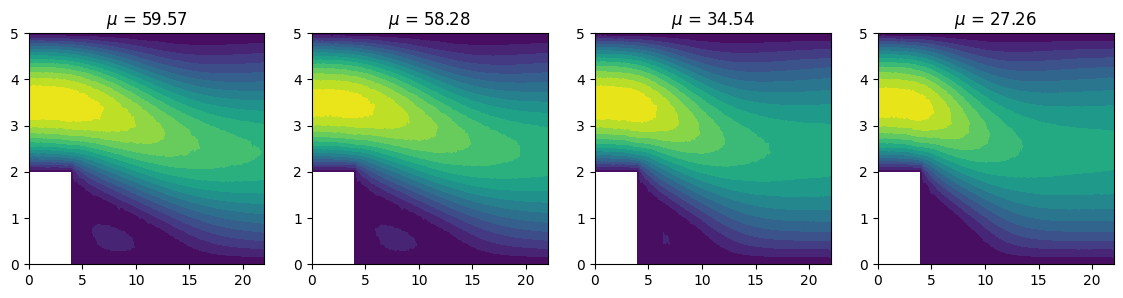

In [30]:
from smithers.dataset import NavierStokesDataset
dataset = NavierStokesDataset()

fig, axs = plt.subplots(1, 4, figsize=(14, 3))
for ax, p, u in zip(axs, dataset.params[:4], dataset.snapshots['mag(v)'][:4]):
    ax.tricontourf(dataset.triang, u, levels=16)
    ax.set_title(f'$\mu$ = {p[0]:.2f}')

The *snapshots* - aka the numerical solutions computed for several parameters - and the corresponding parameters are the only data we need to train the model, in order to predict for any new test parameter the solution.
To properly validate the accuracy, we initially split the 500 snapshots into the training dataset (90% of the original data) and the testing one (the reamining 10%). It must be said that, to plug the snapshots into **PINA**, we have to cast them to `LabelTensor` objects.

In [31]:
u = torch.tensor(dataset.snapshots['mag(v)']).float()
p = torch.tensor(dataset.params).float()

p = LabelTensor(p, labels=['mu'])
u = LabelTensor(u, labels=[f's{i}' for i in range(u.shape[1])])

ratio_train_test = 0.9
n = u.shape
n_train = int(u.shape[0] * ratio_train_test)
n_test = u - n_train
u_train, u_test = u[:n_train], u[n_train:]
p_train, p_test = p[:n_train], p[n_train:]

It is now time to define the problem! We inherit from `ParametricProblem` (since the space invariant typically of this methodology), just defining a simple *input-output* condition.

In [32]:
class SnapshotProblem(ParametricProblem):
    output_variables = [f's{i}' for i in range(u.shape[1])]
    parameter_domain = CartesianDomain({'mu': [0, 100]})

    conditions = {
        'io': Condition(input_points=p, output_points=u)
    }

Then, we define the model we want to use: basically we have a MLP architecture that takes in input the parameter and return the *modal coefficients*, so the reduced dimension representation (the coordinates in the POD space). Such latent variable is the projected to the original space using the POD modes, which are computed and stored in the `PODLayer` object.

In [33]:
class PODNN(torch.nn.Module):
    """
    Proper orthogonal decomposition with neural network model.
    """

    def __init__(self, pod_rank, layers, func):
        """
        
        """
        super().__init__()
        
        self.pod = PODLayer(pod_rank)
        self.nn = FeedForward(
            input_dimensions=1,
            output_dimensions=pod_rank,
            layers=layers,
            func=func
        )
            

    def forward(self, x):
        """
        Defines the computation performed at every call.

        :param x: The tensor to apply the forward pass.
        :type x: torch.Tensor
        :return: the output computed by the model.
        :rtype: torch.Tensor
        """
        coefficents = self.nn(x)
        return self.pod.expand(coefficents)

    def fit_pod(self, x):
        """
        Just call the :meth:`pina.model.layers.PODLayer.fit` method of the
        :attr:`pina.model.layers.PODLayer` attribute.
        """
        self.pod.fit(x)

We highlight that the POD modes are directly computed by means of the singular value decomposition (computed over the input data), and not trained using the back-propagation approach. Only the weights of the MLP are actually trained during the optimization loop.

In [34]:
poisson_problem = SnapshotProblem()

pod_nn = PODNN(pod_rank=20, layers=[10, 10, 10], func=torch.nn.Tanh)
pod_nn.fit_pod(u)

pinn_stokes = SupervisedSolver(
    problem=poisson_problem, 
    model=pod_nn, 
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 0.0001})

Now that we set the `Problem` and the `Model`, we have just to train the model and use it for predict the test snapshots.

In [35]:
trainer = Trainer(
    solver=pinn_stokes,
    max_epochs=1000,
    batch_size=100,
    log_every_n_steps=5,
    accelerator='cpu')
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 460   
----------------------------------------
460       Trainable params
0         Non-trainable params
460       Total params
0.002     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 5/5 [00:00<00:00, 286.50it/s, v_num=20, mean_loss=0.902]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 5/5 [00:00<00:00, 248.36it/s, v_num=20, mean_loss=0.902]


Done! Now the computational expensive part is over, we can load in future the model to infer new parameters (simply loading the checkpoint file automatically created by `Lightning`) or test its performances. We measure the relative error for the training and test datasets, printing the mean one.

In [36]:
u_test_pred = pinn_stokes(p_test)
u_train_pred = pinn_stokes(p_train)

relative_error_train = torch.norm(u_train_pred - u_train)/torch.norm(u_train)
relative_error_test = torch.norm(u_test_pred - u_test)/torch.norm(u_test)

print('Error summary:')
print(f'  Train: {relative_error_train.item():e}')
print(f'  Test:  {relative_error_test.item():e}')

Error summary:
  Train: 3.865598e-02
  Test:  3.593161e-02


We can of course also plot the solutions predicted by the `PODNN` model, comparing them to the original ones. We can note here some differences, especially for low velocities, but improvements can be accomplished thanks to longer training.

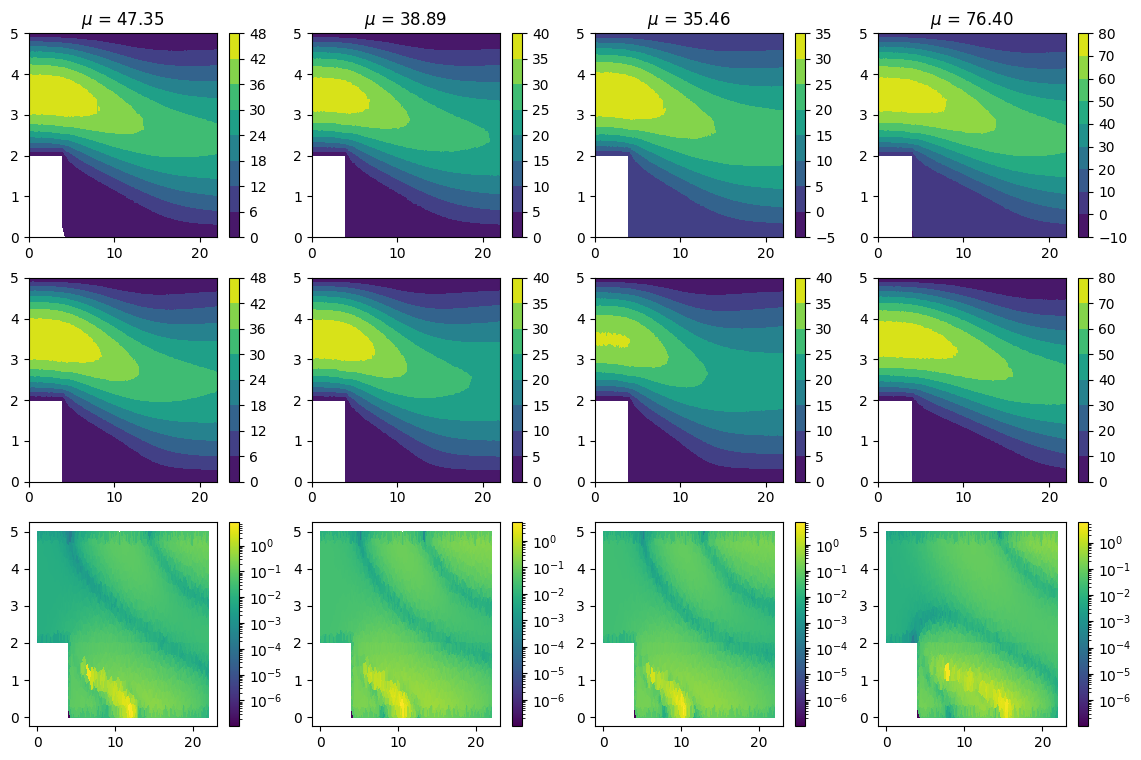

In [37]:
idx = torch.randint(0, len(u_test_pred), (4,))
u_idx = pinn_stokes(p_test[idx])
import numpy as np
import matplotlib
fig, axs = plt.subplots(3, 4, figsize=(14, 9))

relative_error = np.abs(u_test[idx] - u_idx.detach())
relative_error = np.where(u_test[idx] < 1e-7, 1e-7, relative_error/u_test[idx])
                        
for i, (idx_, u_, err_) in enumerate(zip(idx, u_idx, relative_error)):
    cm = axs[0, i].tricontourf(dataset.triang, u_.detach())
    axs[0, i].set_title(f'$\mu$ = {p_test[idx_].item():.2f}')
    plt.colorbar(cm)

    cm = axs[1, i].tricontourf(dataset.triang, u_test[idx_].flatten())
    plt.colorbar(cm)

    cm = axs[2, i].tripcolor(dataset.triang, err_, norm=matplotlib.colors.LogNorm())
    plt.colorbar(cm)


plt.show()